## InSAR time-series estimator from a stack of interferograms ##

This notebook is for the development and testing, not suitable for generic use or references who is not familiar with time-series inversion algorithms.

In [6]:
## Develop & Test InSAR Time-series Estimator from a Stack of Interferograms

import os
import sys
import numpy as np
#from numpy.linalg import inv, pinv, svd, matrix_rank
from scipy.linalg import pinv2, inv, lstsq, LinAlgError
import matplotlib.pyplot as plt
from pysar.objects import ifgramStack, timeseries, sensor
from pysar.utils import readfile, ptime, network as pnet, plot as pp
from pysar import ifgram_inversion as ifginv

work_dir = os.path.expanduser('~/insarlab/PYSAR_EXAMPLE/AlcedoSenDT128/PYSAR');      y, x = 431, 424
os.chdir(work_dir)
print('Go to directory: '+work_dir)
sensor = sensor.project_name2sensor_name(work_dir)[0]
ifgram_file = 'INPUTS/ifgramStack.h5'

# configuration parameters
if sensor in ['Env', 'Alos']:
    mask_threshold = 0.2
elif sensor in ['Sen']:
    mask_threshold = 0.4
min_norm_velocity = True
weight_func = 'fim'
mask_dataset_name = 'coherence'
mask_threshold = 0.4
water_mask_file = None
skip_zero_phase = True

##################################################################
stack_obj = ifgramStack(ifgram_file)
stack_obj.open(print_msg=False)
# get ref_phase
ref_phase = stack_obj.get_reference_phase(skip_reference=False, dropIfgram=True)
# get tbase_diff
date_list = stack_obj.get_date_list(dropIfgram=True)
tbase = np.array(ptime.date_list2tbase(date_list)[0], np.float32) / 365.25
tbase_diff = np.diff(tbase).reshape(-1, 1)
num_date = len(date_list)
L = int(stack_obj.metadata['ALOOKS']) * int(stack_obj.metadata['RLOOKS'])
print('Done.')

Go to directory: /Users/yunjunz/insarlab/PYSAR_EXAMPLE/AlcedoSenDT128/PYSAR
reference pixel in y/x: (135, 637) from dataset: unwrapPhase
Done.


number of interferograms: 475
number of acquisitions  : 98
reading unwrapPhase in (454, 258, 455, 259) * 475 ...
use input reference phase
reading coherence in (454, 258, 455, 259) * 475 ...
mask out pixels with coherence < 0.4
reading coherence in (454, 258, 455, 259) * 475 ...
convert coherence to weight using Fisher Information Index (Seymour & Cumming, 1994)
skip phase with zero value

***WARNING: Singular design matrix!
***Exit.

***WARNING: Singular design matrix!
max perpendicular baseline: 146.66 m
max temporal      baseline: 84.0 days


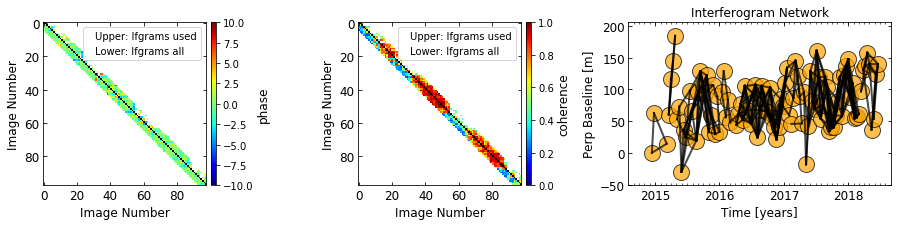

316

In [8]:
## data preparation function
def read_data(box, skip_zero_phase=True, display=True):
    # Design matrix
    date12_list = stack_obj.get_date12_list(dropIfgram=True)
    num_ifgram = len(date12_list)
    
    # Initialization of output matrix
    if display:
        print('number of interferograms: {}'.format(num_ifgram))
        print('number of acquisitions  : {}'.format(num_date))

    # Read/Mask unwrapPhase
    #box = (x, y, x+1, y+1)
    ifgram = ifginv.read_unwrap_phase(stack_obj, box, ref_phase, skip_zero_phase=skip_zero_phase, print_msg=display)
    ifgram = ifginv.mask_unwrap_phase(ifgram, stack_obj, box, mask_ds_name=mask_dataset_name, mask_threshold=mask_threshold, print_msg=display)
    coh = ifginv.read_coherence(stack_obj, box=box, dropIfgram=True)
    weight = ifginv.coherence2weight(coh, weight_func=weight_func, L=L, epsilon=5e-2)
    weight_sqrt = np.sqrt(weight)
    ifgram0 = np.array(ifgram)
    date12_list0 = list(date12_list)

    A, B = stack_obj.get_design_matrix4timeseries(date12_list=date12_list)
    # Skip Zero Phase Value
    if skip_zero_phase and not np.all(ifgram):
        if display:
            print('skip phase with zero value')
        idx = (ifgram != 0.).flatten()
        date12_list = np.array(date12_list)[idx].tolist()
        A = A[idx, :]
        B = B[idx, :]
        if (np.sum(A != 0., axis=0) < 1).any() and display:
            print('\n***WARNING: Not all acquisitions have > 2 observations covered!')
        try:
            inv(np.dot(B.T, B))
        except LinAlgError:
            if display:
                print('\n***WARNING: Singular design matrix!\n***Exit.')

        ifgram = ifgram[idx, :]
        #coh = coh[idx, :]
        if weight_sqrt is not None:
            weight_sqrt = weight_sqrt[idx, :]

    if np.linalg.matrix_rank(A) < A.shape[1] and display:
        print('\n***WARNING: Singular design matrix!')

    # display
    if display:
        pdict = {}
        pdict['disp_title'] = False
        pbase_list = stack_obj.get_perp_baseline_timeseries(dropIfgram=False)
        date12_drop = list(set(date12_list0) - set(date12_list))
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[16,3])
        pdict['ylim'] = (-10, 10)
        pdict['cbar_label'] = 'phase'
        pp.plot_coherence_matrix(ax[0], date12_list0, ifgram0.flatten().tolist(),
                                 date12List_drop=date12_drop, plot_dict=pdict)
        pdict['ylim'] = (0., 1.)
        pdict['cbar_label'] = 'coherence'
        pp.plot_coherence_matrix(ax[1], date12_list0, coh.flatten().tolist(),
                                 date12List_drop=date12_drop, plot_dict=pdict)
        pp.plot_network(ax[2], date12_list, date_list, pbase_list)
        plt.show()
    return A, B, ifgram, weight_sqrt

x, y = 454, 258
box = (x, y, x+1, y+1)
A, B, ifgram, weight_sqrt = read_data(box)
A.shape[0]

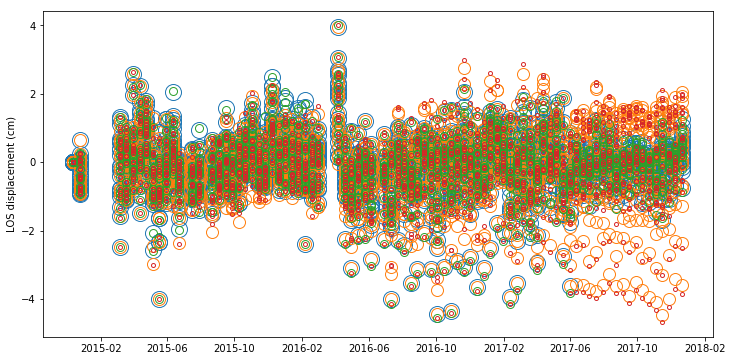

In [65]:
## Check result on pixels with anomalies

xx = np.array([475, 470, 447, 536, 409, 510, 566, 368, 596, 419, 411, 619, 291,
       355, 459, 259, 243, 251, 558, 412, 330])
yy = np.array([146, 147, 156, 175, 184, 190, 196, 206, 213, 226, 237, 245, 248,
       261, 261, 301, 360, 369, 390, 397, 425])
#xx, yy = [454], [258]

# display
phase2range = -1*float(stack_obj.metadata['WAVELENGTH'])/(4.*np.pi)
dates = ptime.date_list2vector(date_list)[0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[12, 6])

rcond = 1e-3
redun_ratio = 1
ts_A = np.zeros((num_date, len(xx)), np.float32)
ts_B = np.zeros(ts_A.shape, np.float32)
ts_Aw = np.zeros(ts_A.shape, np.float32)
ts_Bw = np.zeros(ts_A.shape, np.float32)

for i in range(len(xx)):
    x, y = xx[i], yy[i]
    box = (x, y, x+1, y+1)
    A, B, ifgram, weight_sqrt = read_data(box, skip_zero_phase=False, display=False)

    ts_A[:, i] = ifginv.estimate_timeseries(A, B, tbase_diff, ifgram,
                                      weight_sqrt=None,
                                      min_norm_velocity=False,rcond=rcond,
                                      redun_ratio=redun_ratio)[0].flatten()
    ts_B[:, i] = ifginv.estimate_timeseries(A, B, tbase_diff, ifgram,
                                              weight_sqrt=None,
                                              min_norm_velocity=True,rcond=rcond,
                                              redun_ratio=redun_ratio)[0].flatten()
    ts_Aw[:, i] = ifginv.estimate_timeseries(A, B, tbase_diff, ifgram,
                                       weight_sqrt=weight_sqrt,
                                       min_norm_velocity=False,rcond=rcond,
                                       redun_ratio=redun_ratio)[0].flatten()
    ts_Bw[:, i] = ifginv.estimate_timeseries(A, B, tbase_diff, ifgram,
                                                weight_sqrt=weight_sqrt,
                                                min_norm_velocity=True,rcond=rcond,
                                                redun_ratio=redun_ratio)[0].flatten()

    #print('number of acquisitions: {}'.format(num_date))
    #print('Temporal coherence Code: {}'.format(tcoh))
    #print('Temporal coherence A   : {}'.format(temp_coh_A))
    #print('Temporal coherence B   : {}'.format(temp_coh_B))
    #print('Temporal coherence Aw  : {}'.format(temp_coh_Aw))
    #print('Temporal coherence Bw  : {}'.format(temp_coh_Bw))

ax.plot(dates, ts_A  * phase2range * 100., 'o', label='A',  color=pp.mplColors[0],  mfc='none', ms=16)
ax.plot(dates, ts_B  * phase2range * 100., 'o', label='B',  color=pp.mplColors[1],  mfc='none', ms=12)
ax.plot(dates, ts_Aw * phase2range * 100., 'o', label='Aw', color=pp.mplColors[2],  mfc='none', ms=8)
ax.plot(dates, ts_Bw * phase2range * 100., 'o', label='Bw', color=pp.mplColors[3],  mfc='none', ms=4)

ax.set_ylabel('LOS displacement (cm)')
#ax[0].set_title('A')
#ax[1].set_title('B')
#ax[2].set_title('Aw')
#ax[3].set_title('Bw')
#plt.legend()
plt.show()

In [9]:
## Test Running Spped of Different Inversion Strategies

from timeit import timeit

def test_singular1():
    try:
        #inv(np.dot(A.T, A))
        inv(np.dot(B.T, B))
    except:
        pass
    return

def test_singular2():
    (np.sum(A != 0., axis=0) <= 2).any()
    
def test_singular3(epsilon=sys.float_info.epsilon):
    np.linalg.cond(np.dot(B.T, B)) >= 1/epsilon

#tb1 = timeit(stmt="inv_B1()", globals=globals(), number=100)
#tb2 = timeit(stmt="inv_B2()", globals=globals(), number=100)
#print('time B1: {}'.format(tb1))
#print('time B2: {}'.format(tb2))

t1 = timeit(stmt="test_singular1()", globals=globals(), number=100)
t2 = timeit(stmt="test_singular2()", globals=globals(), number=100)
t3 = timeit(stmt="test_singular3()", globals=globals(), number=100)
#taw1 = timeit(stmt="inv_AW1()", globals=globals(), number=100)
#taw2 = timeit(stmt="inv_AW2()", globals=globals(), number=100)

print('time 1: {}'.format(t1))
print('time 2: {}'.format(t2))
print('time 3: {}'.format(t3))
#print('time AW1: {}'.format(taw1))
#print('time AW2: {}'.format(taw2))

#tb1 = timeit(stmt="inv_B1()", globals=globals(), number=1)
#tb2 = timeit(stmt="inv_B2()", globals=globals(), number=1)
#print('time B1: {}'.format(tb1))
#print('time B2: {}'.format(tb2))

#tc1 = timeit(stmt='check_21',  globals=globals(), number=100)
#tc2 = timeit(stmt='check_22',  globals=globals(), number=100)
#print('time check 1: {}'.format(tc1))
#print('time check 2: {}'.format(tc2))

time 1: 0.06373486500160652
time 2: 0.004848778000450693
time 3: 0.17236119599874655
